Author: Adrian Swartz<br>
Date: 3/29/2019


# Solutions to Andew Ng's coursera problems
## Example 5: Regularized Linear Regression and Bias vs. Variance

Andrew Ng's course is designed for the solutions to be worked through in Octave (similar to matlab). However, I am going to do these problems in python (within a jupyter notebook) and demonstrate how various approaches can be implemented in python.

To some degree, I have already touched on model evaluation and bias/variance in the Logistic Regression examples.

This notebook is structured as follows:<br>
[Regularized Linear Regression and Bias vs. Variance](#Part1)<br>
1. [Simple Linear Regression with Regularization](#1)<br>
    1a. [Exploratory Data Analysis](#eda)<br>
    1b. [Preprocess the Data](#prep)<br>
    1c. [Regularized Cost and Gradient Functions for Linear Regression](#funcs)<br>
    1d. [Optimize the (Linear) Model Parameters](#opt)<br>
    1e. [Model Evaluation](#me)<br>
    

2. [Linear Regression with Regularization and Non-linear Features](#2)<br>
    2a. [Non-Linear Feature Generation](#fg)<br>
    2b. [Optimize the (Linear) Model Parameters](#opt2)<br>
    2c. [Model Evaluation](#me2)<br>
    
    
3. [Linear Regression with Regularization and Non-linear Features with sklearn](#3)<br>
    3a. [Non-Linear Feature Generation](#fg1)<br>
    3b. [Regularized Linear Regression with sklearn](#sklearn)<br>
    

4. [Bias vs. Variance](#4)<br>





***

For this exercise, we will import several python packages: NumPy (numerical python for matrix manupulations and advanced math), pandas (DataFrames offer a useful platform for importing data and performing exploratory data analysis), matplotlib and seaborn for data visualization.

In [1]:
# import standard packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
cp=sns.color_palette()

# import a few special packages we'll use for this example
from scipy.io import loadmat
from sklearn.preprocessing import PolynomialFeatures
from scipy.optimize import minimize
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

<a id="Part1"></a>
# Regularized Linear Regression and Bias vs. Variance
Prompt:<br>
Implement regularized linear regression and use it to study models with different bias-variance properties.


In the first half of the exercise, you will implement regularized linear regression to predict the amount of water flowing out of a dam using the change of water level in a reservoir. In the next half, you will go through some diagnostics of debugging learning algorithms and examine the effects of bias v.s. variance.


***

OK. Let's dive into the data and begin building the frameworks for regularized linear regression.

<a id="eda"></a>
# Exploratory Data Analysis

In [2]:
data = loadmat('ex5/ex5data1.mat')
data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: GLNXA64, Created on: Fri Nov  4 22:27:26 2011',
 '__version__': '1.0',
 '__globals__': [],
 'X': array([[-15.93675813],
        [-29.15297922],
        [ 36.18954863],
        [ 37.49218733],
        [-48.05882945],
        [ -8.94145794],
        [ 15.30779289],
        [-34.70626581],
        [  1.38915437],
        [-44.38375985],
        [  7.01350208],
        [ 22.76274892]]),
 'y': array([[ 2.13431051],
        [ 1.17325668],
        [34.35910918],
        [36.83795516],
        [ 2.80896507],
        [ 2.12107248],
        [14.71026831],
        [ 2.61418439],
        [ 3.74017167],
        [ 3.73169131],
        [ 7.62765885],
        [22.7524283 ]]),
 'Xtest': array([[-33.31800399],
        [-37.91216403],
        [-51.20693795],
        [ -6.13259585],
        [ 21.26118327],
        [-40.31952949],
        [-14.54153167],
        [ 32.55976024],
        [ 13.39343255],
        [ 44.20988595],
        [ -1.14267768],
        [-

In [3]:
X_train = data['X']
X_val = data['Xval']
X_test = data['Xtest']

y_train = data['y']
y_val = data['yval']
y_test = data['ytest']

Text(0, 0.5, 'Water Flow')

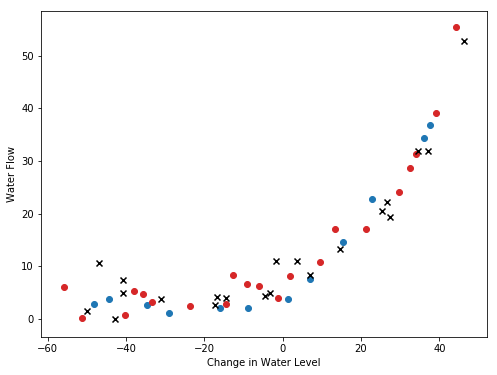

In [4]:
fig, ax = plt.subplots(figsize=(8,6))
plt.scatter(X_train, y_train)
plt.scatter(X_test, y_test, color=cp[3])
plt.scatter(X_val, y_val, marker='x', color='black')
ax.set_xlabel('Change in Water Level')
ax.set_ylabel('Water Flow')

In [5]:
X_train.shape, X_test.shape, X_val.shape

((12, 1), (21, 1), (21, 1))

In [6]:
y_train.shape, y_test.shape, y_val.shape

((12, 1), (21, 1), (21, 1))

There's hardly any data, but because it's well sampled (can see that from the graph), this will work well enough for our purposes of implementing regularized linear regression and playing around with validation techniques. 

<a id="eda"></a>
# Preprocess the Data

In [7]:
poly = PolynomialFeatures(1)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_train = np.matrix(data['X'])
X_test = np.matrix(data['Xtest'])
X_val = np.matrix(data['Xval'])
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
X_val = poly.fit_transform(X_val)

y_train = np.matrix(data['y'])
y_test = np.matrix(data['ytest'])
y_val = np.matrix(data['yval'])


X_train.shape, X_test.shape, X_val.shape

((12, 2), (21, 2), (21, 2))

In [8]:
X_train[:5] # checking that the bias term is added.

array([[  1.        , -15.93675813],
       [  1.        , -29.15297922],
       [  1.        ,  36.18954863],
       [  1.        ,  37.49218733],
       [  1.        , -48.05882945]])

In [9]:
#Initialize theta - needs to be an array to work with scipy.optimize functions
theta = np.zeros(X_train.shape[1])
theta.shape

(2,)

<a id="funcs"></a>
# Regularized Cost and Gradient Functions for Linear Regression

In [10]:
def Regularized_Cost(theta, X, y, reg_scale):
    """ Calculates the regularized cost function for logistic regression
    input
    theta: a numpy array of length n; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    reg_scale: a float; strength of the regularization

    output
    cost: the sum of the ordinary least squares over all the data
    """
    theta = np.matrix(theta)
    M = len(X)
    
    cost = np.sum( np.power(((X * theta.T) - y), 2) ) / (2*M)
    cost += (reg_scale * np.sum(np.power(theta[:,1:theta.shape[1]], 2)) / (2 * M))
    return cost

In [11]:
Regularized_Cost(theta, X_train, y_train, 1)

140.95412088055392

In [12]:
def Regularized_Gradient(theta, X, y, reg_scale):
    """ Calculates the regularized gradient of the logistic regression cost function 
    input
    theta: a 1 x n matrix; the model parameters
    X: an m x n matrix; instances x features
    y: an m x 1 matrix; target variable
    reg_scale: a float; strength of the regularization
    
    output
    gradient: a numpy array of floats of lenth n
    """
    M=len(X)
    theta=np.matrix(theta)
    parameters = int(theta.shape[1])
    grad = np.zeros(parameters)
    
    error = (X * theta.T) - y
    
    for i in range(parameters):
        
        if (i == 0):
            grad[i] = np.sum(np.multiply(error, np.matrix(X[:,i]).T)) / M
        else:
            grad[i] = (np.sum(np.multiply(error, np.matrix(X[:,i]).T)) / M) 
            grad[i] += (reg_scale * theta[:,i] / M)
    
    return grad

In [13]:
Regularized_Gradient(theta, X_train, y_train, 1)

array([ -11.21758933, -245.65199649])

<a id="opt"></a>
# Optimize the (Linear) Model Parameters

In [14]:
result = minimize(fun=Regularized_Cost, x0=theta, args=(X_train,y_train,1), method='TNC', \
                      jac=Regularized_Gradient, options={'maxiter':1000})
result

     fun: 22.379541822940272
     jac: array([-1.42435885e-09,  4.35851235e-08])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 9
     nit: 4
  status: 0
 success: True
       x: array([13.08771416,  0.367742  ])

In [15]:
#Generate the predictions
x = np.matrix(np.linspace(-60,60, num=100)).T
x_ = poly.fit_transform(x)
y_pred = (x_ * np.matrix(result.x).T)

In [16]:
x.shape, y_pred.shape

((100, 1), (100, 1))

Text(0, 0.5, 'Water Flow')

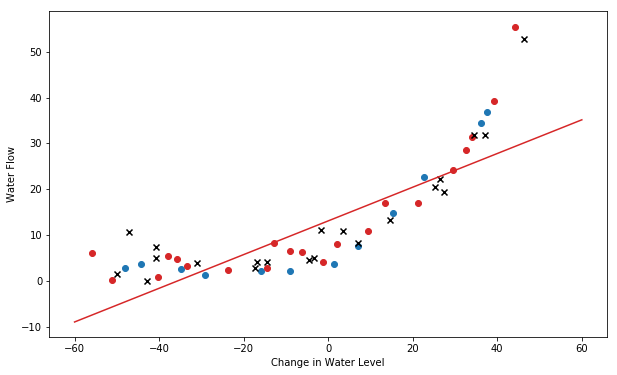

In [17]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data['X'], data['y']) # plot the data
plt.scatter(data['Xtest'], data['ytest'], color=cp[3])
plt.scatter(data['Xval'], data['yval'], marker='x', color='black')
plt.plot(x, y_pred, color=cp[3]) # plot the fit
ax.set_xlabel('Change in Water Level')
ax.set_ylabel('Water Flow')

<a id="me"></a>
# Model Evaluation

In [18]:
y_pred = (X_train * np.matrix(result.x).T)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print('Training Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Training Error
Mean Absolute Error: 5.978; Mean Squared Error: 44.75; R^2 score: 0.7133
 


In [19]:
y_pred_test = (X_test * np.matrix(result.x).T)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Test Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Test Error
Mean Absolute Error: 5.816; Mean Squared Error: 65.01; R^2 score: 0.6772
 


In [20]:
y_pred_val = (X_val * np.matrix(result.x).T)

mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print('Val Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Val Error
Mean Absolute Error: 5.926; Mean Squared Error: 58.87; R^2 score: 0.6358
 


<a id="2"></a>
# Linear Regression with Regularization and Non-linear Features

In this section I will add non-linear features up to fourth order using sklearn's Ploly

<a id="fg"></a>
# Non-Linear Feature Generation

In [21]:
poly = PolynomialFeatures(4)  # for 4th order polynomial feature generation

X_train = np.matrix(data['X'])
X_test = np.matrix(data['Xtest'])
X_val = np.matrix(data['Xval'])
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
X_val = poly.fit_transform(X_val)

y_train = np.matrix(data['y'])
y_test = np.matrix(data['ytest'])
y_val = np.matrix(data['yval'])

#Initialize theta - needs to be an array to work with scipy.optimize functions
theta = np.zeros(X_train.shape[1])
theta.shape

(5,)

In [22]:
result = minimize(fun=Regularized_Cost, x0=theta, args=(X_train,y_train,1), method='TNC', \
                      jac=Regularized_Gradient, options={'maxiter':50000})
result

     fun: 2.7689404886034965
     jac: array([-1.16105868e+00, -1.13306831e-01, -7.46139981e-01, -8.90415076e+01,
       -5.74325994e+02])
 message: 'Max. number of function evaluations reached'
    nfev: 50000
     nit: 16666
  status: 3
 success: False
       x: array([ 9.39515215e-02,  5.21429840e-01,  2.46017040e-02, -7.28689907e-05,
       -7.13749602e-06])

In [23]:
#Generate the predictions
x = np.matrix(np.linspace(-60,60, num=100)).T
x_ = poly.fit_transform(x)
y_pred = (x_ * np.matrix(result.x).T)

Text(0, 0.5, 'Water Flow')

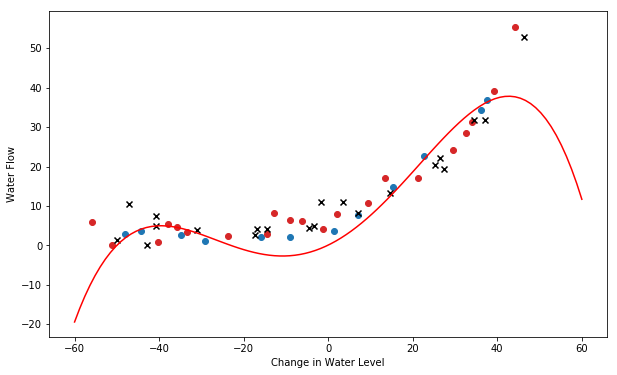

In [24]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data['X'], data['y']) # plot the data
plt.scatter(data['Xtest'], data['ytest'], color=cp[3])
plt.scatter(data['Xval'], data['yval'], marker='x', color='black')
plt.plot(x, y_pred, color='red') # plot the fit
ax.set_xlabel('Change in Water Level')
ax.set_ylabel('Water Flow')

Definitely over fitting!
<a id="me2"></a>
# Model Evaluation

In [25]:
y_pred = (X_train * np.matrix(result.x).T)
mae = mean_absolute_error(y_train, y_pred)
mse = mean_squared_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print('Training Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Training Error
Mean Absolute Error: 1.906; Mean Squared Error: 5.515; R^2 score: 0.9647
 


In [26]:
y_pred_test = (X_test * np.matrix(result.x).T)

mae = mean_absolute_error(y_test, y_pred_test)
mse = mean_squared_error(y_test, y_pred_test)
r2 = r2_score(y_test, y_pred_test)

print('Test Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Test Error
Mean Absolute Error: 5.433; Mean Squared Error: 50.29; R^2 score: 0.7503
 


In [27]:
y_pred_val = (X_val * np.matrix(result.x).T)

mae = mean_absolute_error(y_val, y_pred_val)
mse = mean_squared_error(y_val, y_pred_val)
r2 = r2_score(y_val, y_pred_val)

print('Val Error')
print('Mean Absolute Error: {:.4}; Mean Squared Error: {:.4}; R^2 score: {:.4}'.format(mae, mse, r2))
print(' ')

Val Error
Mean Absolute Error: 5.257; Mean Squared Error: 41.45; R^2 score: 0.7436
 


The over fitting is pretty clear now. The model has a much lower MSE for the training data, but performs poorly when applied to the test and val sets.


<a id="3"></a>
# Linear Regression with Regularization and Non-linear Features with sklearn

In this section I will add non-linear features up to fourth order using sklearn's Ploly

<a id="fg1"></a>
# Non-Linear Feature Generation


In [28]:
poly = PolynomialFeatures(4)  # for 4th order polynomial feature generation

X_train = np.matrix(data['X'])
X_test = np.matrix(data['Xtest'])
X_val = np.matrix(data['Xval'])
X_train = poly.fit_transform(X_train)
X_test = poly.fit_transform(X_test)
X_val = poly.fit_transform(X_val)

y_train = np.matrix(data['y'])
y_test = np.matrix(data['ytest'])
y_val = np.matrix(data['yval'])

#Initialize theta - needs to be an array to work with scipy.optimize functions
theta = np.zeros(X_train.shape[1])
theta.shape

(5,)

<a id="sklearn"></a>
# Regularized Linear Regression with sklearn

`LinearRegression` in sklearn does not include regularization. Instead, we have to explicitely call either [Ridge](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge) (L2) or [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso) (L1) functions. See the documentation for more information.  The first paramter for these objects is `alpha` which is the same as $\lambda$ in Andrew Ng's course. `alpha` is the true regularization strength, while $C$ (which appears in LogisticRegression, SVM, and other classification techniques) is the inverse regularization strength (i.e. $C$ = 1/$\lambda$).

In [29]:
#unregularized ordinary least squares linear regression
linreg = LinearRegression(fit_intercept=False).fit(X_train, y_train)

# Ridge regression with regulatization strength, alpha=1
rdg_1 = Ridge(alpha=1.0, fit_intercept=False).fit(X_train, y_train)

# Ridge regression with regulatization strength, alpha=1
rdg_100000 = Ridge(alpha=100000, fit_intercept=False).fit(X_train, y_train)

# Ridge regression with regulatization strength, alpha=1
rdg_p001 = Ridge(alpha=.001, fit_intercept=False).fit(X_train, y_train)

In [30]:
#Generate the predictions
x = np.matrix(np.linspace(-60,60, num=100)).T
x_ = poly.fit_transform(x)
linreg_pred = (x_ * np.matrix(linreg.coef_).T)
rdg_1_pred = (x_ * np.matrix(rdg_1.coef_).T)
rdg_100000_pred = (x_ * np.matrix(rdg_100000.coef_).T)
rdg_p001_pred = (x_ * np.matrix(rdg_p001.coef_).T)

In [31]:
x.shape, linreg_pred.shape

((100, 1), (100, 1))

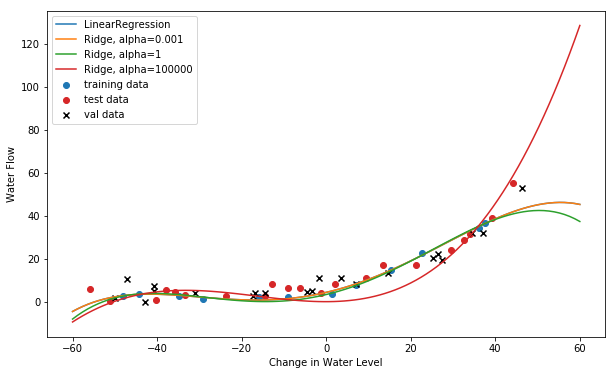

In [32]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data['X'], data['y'], label='training data') # plot the data
plt.scatter(data['Xtest'], data['ytest'], color=cp[3], label='test data')
plt.scatter(data['Xval'], data['yval'], marker='x', color='black', label='val data')
plt.plot(x, linreg_pred, label='LinearRegression') 
plt.plot(x, rdg_p001_pred, label='Ridge, alpha=0.001') 
plt.plot(x, rdg_1_pred, label='Ridge, alpha=1') 
plt.plot(x, rdg_100000_pred, label='Ridge, alpha=100000') 
ax.set_xlabel('Change in Water Level')
ax.set_ylabel('Water Flow')
plt.legend()


In [33]:
# Lasso regression with regulatization strength, alpha=1
lso_1 = Lasso(alpha=1.0, fit_intercept=False).fit(X_train, y_train)

# Lasso regression with regulatization strength, alpha=1
lso_100000 = Lasso(alpha=100000, fit_intercept=False).fit(X_train, y_train)

# Lasso regression with regulatization strength, alpha=1
lso_p001 = Lasso(alpha=.001, fit_intercept=False).fit(X_train, y_train)

#Generate the predictions
x = np.matrix(np.linspace(-60,60, num=100)).T
x_ = poly.fit_transform(x)
lso_1_pred = (x_ * np.matrix(lso_1.coef_).T)
lso_100000_pred = (x_ * np.matrix(lso_100000.coef_).T)
lso_p001_pred = (x_ * np.matrix(lso_p001.coef_).T)

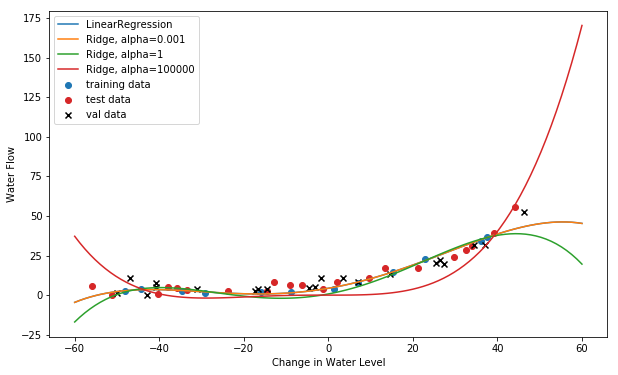

In [34]:
fig, ax = plt.subplots(figsize=(10,6))
plt.scatter(data['X'], data['y'], label='training data') # plot the data
plt.scatter(data['Xtest'], data['ytest'], color=cp[3], label='test data')
plt.scatter(data['Xval'], data['yval'], marker='x', color='black', label='val data')
plt.plot(x, linreg_pred, label='LinearRegression') 
plt.plot(x, lso_p001_pred, label='Ridge, alpha=0.001') 
plt.plot(x, lso_1_pred, label='Ridge, alpha=1') 
plt.plot(x, lso_100000_pred, label='Ridge, alpha=100000') 
ax.set_xlabel('Change in Water Level')
ax.set_ylabel('Water Flow')
plt.legend()


We can see from these two graphs that Lasso (L1) and Ridge (L2) regularizations provide quite different results. Lasso penalizes outliers and can also reduce the feature weights to zero. For this reason, Lasso can be more effective when features are highly correlated (although you can't choose which one it reduces the weight for).  From the graph you can see that for very strong regularization, Lasso does a better job of reducing the fourth-order and third-order components.

<a id="4"></a>
# Bias vs. Variance
 

# Learning Curves

Let's use sklearn's capabalities for this. I'm unlikely to ever want to implement this manually for more complex models. So might as well spend the time working with sklearn.

In [35]:
X = np.matrix(np.vstack((data['X'], data['Xtest'], data['Xval'])))
y = np.matrix(np.vstack((data['y'], data['ytest'], data['yval'])))
X.shape, y.shape

((54, 1), (54, 1))

In [36]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.01, 1.0, 10)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt


<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

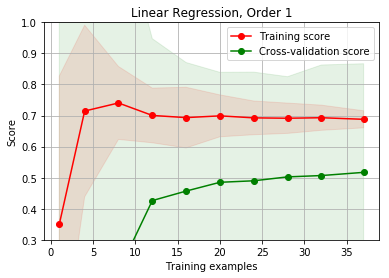

In [37]:
poly = PolynomialFeatures(1)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_poly = poly.fit_transform(X)

title = "Linear Regression, Order 1"
# Cross validation with 2 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

estimator = LinearRegression(fit_intercept=False)

plot_learning_curve(estimator, title, X_poly, y, ylim=(0.3, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

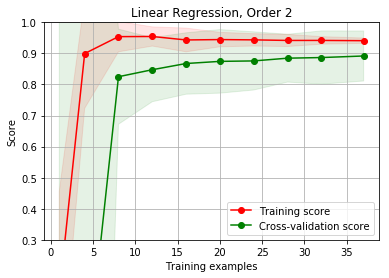

In [38]:
poly = PolynomialFeatures(2)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_poly = poly.fit_transform(X)

title = "Linear Regression, Order 2"
# Cross validation with 2 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

estimator = LinearRegression(fit_intercept=False)

plot_learning_curve(estimator, title, X_poly, y, ylim=(0.3, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

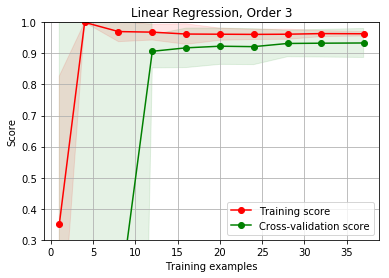

In [39]:
poly = PolynomialFeatures(3)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_poly = poly.fit_transform(X)

title = "Linear Regression, Order 3"
# Cross validation with 2 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

estimator = LinearRegression(fit_intercept=False)

plot_learning_curve(estimator, title, X_poly, y, ylim=(0.3, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

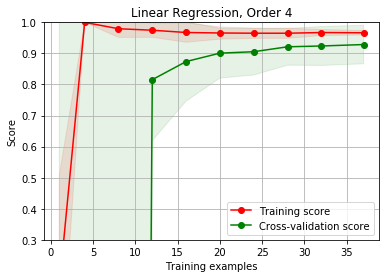

In [40]:
poly = PolynomialFeatures(4)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_poly = poly.fit_transform(X)

title = "Linear Regression, Order 4"
# Cross validation with 2 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

estimator = LinearRegression(fit_intercept=False)

plot_learning_curve(estimator, title, X_poly, y, ylim=(0.3, 1), cv=cv, n_jobs=4)

<module 'matplotlib.pyplot' from '/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/matplotlib/pyplot.py'>

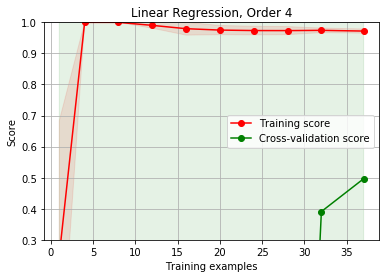

In [47]:
poly = PolynomialFeatures(8)  
# setting =1 leaves the original data (no new non-linear features)
# However, PolynomialFeatures will add the bias term for us

X_poly = poly.fit_transform(X)

title = "Linear Regression, Order 4"
# Cross validation with 2 iterations, higher cv gives smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=40, test_size=0.3, random_state=0)

estimator = LinearRegression(fit_intercept=False)

plot_learning_curve(estimator, title, X_poly, y, ylim=(0.3, 1), cv=cv, n_jobs=4)

# Model Complexity

In [45]:
poly_orders = range(1,7)

X_train = data['X']
X_val = data['Xval']
X_test = data['Xtest']

y_train = data['y']
y_val = data['yval']
y_test = data['ytest']

accs_train=[]
accs_test=[]
for p in poly_orders:
    poly = PolynomialFeatures(p)
    X_train_poly = poly.fit_transform(X_train)
    X_test_poly = poly.fit_transform(X_test)
    
    linreg = LinearRegression(fit_intercept=False).fit(X_train_poly, y_train)
    accs_train.append(linreg.score(X_train_poly, y_train))
    accs_test.append(linreg.score(X_test_poly, y_test))

    


Text(0.5, 1.0, 'Model Complexity Curve')

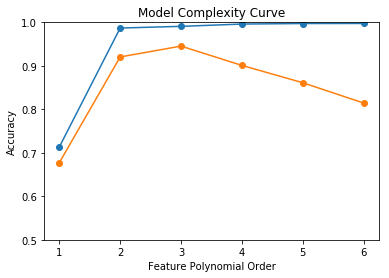

In [46]:
fig, ax = plt.subplots()
plt.plot(poly_orders, accs_train, '-o')
plt.plot(poly_orders, accs_test, '-o')
ax.set_ylim((.5,1))
ax.set_xlabel('Feature Polynomial Order')
ax.set_ylabel('Accuracy')
ax.set_title('Model Complexity Curve')

In my opinion, there isn't really enough data here to pursue this topic much further. There's only 12 data points in the training set provided in the example. Let's move on to bigger and better things!